Conda env: `aops_tenflow`

In [1]:
from time import perf_counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.get_logger().setLevel('ERROR')


c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

## Prepare & Load Dataset

In [2]:
AUTOTUNE = tf.data.AUTOTUNE  # Output: -1 --> <class 'int'>
batch_size = 16
seed = 42

from utils.load_dataset_for_regression_model import load_and_prepare_dataset


## Preview

In [7]:
for text_batch, score_batch in train_ds.take(3):
    for i in range(2):
        text = text_batch.numpy()[i].decode('utf-8')  # Decode bytes to string
        label = score_batch.numpy()[i]
        print(f'Text: {text}')
        print(f'Score: {label}')
    print("_"*500, "\n")
    

Text: We have 0 le x_i<b for i=0,1, ldots,n and x_n>0,x_{n-1}>0. If a>b, and x_nx_{n-1} ldots x_0 represents the number A base a and B base b, whilst x_{n-1}x_{n-2} ldots x_0 represents the number A' base a and B' base b, prove that A'B<AB'.
Score: 1.5102040816326523
Text: Prove that cos{ frac{ pi}{7}}- cos{ frac{2 pi}{7}}+ cos{ frac{3 pi}{7}}= frac{1}{2}
Score: 6.041666666666668
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 

Text: Given real numbers x_1,x_2,y_1,y_2,z_1,z_2 satisfying x_1>0,x_2>0,x_1y_1>z_1^2, and x_2y_2>z_2^2, prove that

In [9]:
temp_ = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
bert_preprocess_model = hub.KerasLayer(temp_)

text_test = ['A social network has 2019 users, some pairs of whom are friends. Whenever user A is friends with user B, user B is also friends with user A. Events of the following kind may happen repeatedly, one at a time: Three users A, B, and C such that A is friends with both B and C, but B and C are not friends, change their friendship statuses such that B and C are now friends, but A is no longer friends with B, and no longer friends with C. All other friendship statuses are unchanged. Initially, 1010 users have 1009 friends each, and 1009 users have 1010 friends each. Prove that there exists a sequence of such events after which each user is friends with at most one other user. Proposed by Adrian Beker, Croatia']
text_test = ['Hello hELlo']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :10]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :10]}')

print(type(text_preprocessed["input_word_ids"]))
print(type(text_preprocessed["input_mask"]))
print(type(text_preprocessed["input_type_ids"]))

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 7592 7592  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0]
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Modeling

In [3]:
class RegressorModel:
    def __init__(self, tfhub_preprocess, tfhub_encoder, seq_length=512):
        self.tfhub_preprocess = tfhub_preprocess
        self.tfhub_encoder = tfhub_encoder
        self.seq_length = seq_length
        self.model = self.__build_model()
        self.history = None
        
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        self.learning_rate = None
        self.optimizer_type = None
        self.loss = None
        self.metrics = None
        self.optimizer = None
        self.__is_compiled = False
        
        self.__is_trained = False

    def __build_model(self):
        # Step 1: Define text input layer
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        
        # Step 2: Tokenize batches of text inputs
        bert_preprocess = hub.load(self.tfhub_preprocess)
        tokenize = hub.KerasLayer(bert_preprocess.tokenize)
        tokenized_input = tokenize(text_input)
        
        # Step 3: Pack input sequences for the Transformer encoder
        bert_pack_inputs = hub.KerasLayer(
            bert_preprocess.bert_pack_inputs,
            arguments=dict(seq_length=self.seq_length))
        encoder_inputs = bert_pack_inputs([tokenized_input])
        
        # Load BERT encoder
        encoder = hub.KerasLayer(self.tfhub_encoder, trainable=True, name='BERT_encoder')
        # Pass encoder inputs through BERT encoder
        outputs = encoder(encoder_inputs)

        # Define classifier layers
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(512, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
        
        return tf.keras.Model(text_input, net)
    
    def compile_model(
        self, 
        train_ds, 
        validation_data,
        epochs, 
        learning_rate, 
        optimizer_type='adamw', 
        loss=tf.keras.losses.mean_squared_error,
        metrics=['mae']):
        
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.loss = loss
        self.metrics = metrics
        
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=int(0.1*num_train_steps),
            optimizer_type=self.optimizer_type
        )
        self.optimizer= optimizer
        
        # Comple model
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.__is_compiled = True
    
    def train(self):
        if self.__is_compiled is False: raise Warning("Model is not compiled yet")
        
        print(f"Model       : {self.tfhub_encoder}")
        print(f"Preprocessor: {self.tfhub_preprocess}\n")

        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
            )
        end = perf_counter()
        print(f"\nTotal training time: {end-start:.2f}s")
        
        self.history = history.history
        self.__is_trained = True
        return history
    
    def evaluate_test(self, test_ds):
        if self.__is_trained is False: raise Warning("Model is not trained yet")

        loss, mae = self.model.evaluate(test_ds)

        return {'loss': loss, 'mae': mae}
    
    def plot_training_history_over_time(self, figsize=(14, 12)):
        if self.history is None: raise Warning("Nothing to plot because model is not trained yet")
        
        print(self.history.keys())
        print("Training history over time")
        
        mae = self.history['mae']
        val_acc = self.history['val_mae']
        loss = self.history['loss']
        val_mae = self.history['val_mae']
        epochs = range(1, len(mae) + 1)
        
        figure, ax = plt.subplots(2, 1, figsize=figsize, layout="constrained")

        plt.subplot(2, 1, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')  # r is for "solid red line"
        plt.plot(epochs, val_mae, 'b', label='Validation loss')  # b is for "solid blue line"
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, mae, 'r', label='Training mae')
        plt.plot(epochs, val_acc, 'b', label='Validation mae')
        plt.title('Training and validation mae')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()

    def predict(self, text):
        """
            text: should parsed like this --> tf.constant(["Your text here!"])
        """
        return self.model.predict(text)

epochs = 40
learning_rate = 1e-6
optimizer_type = 'adamw'
loss = tf.keras.losses.mean_squared_error
metrics = ['mae']

tfhub_handle_preprocess = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3"
tfhub_handle_encoder    = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4"


## Data `IMO`

In [4]:
train_ds, val_ds, test_ds = load_and_prepare_dataset("../data/regression/imo/", seed=seed, batch_size=batch_size, AUTOTUNE=AUTOTUNE)
regressor_model = RegressorModel(tfhub_handle_preprocess, tfhub_handle_encoder)
regressor_model.compile_model(train_ds=train_ds,
                                 validation_data=val_ds,
                                 epochs=epochs, 
                                 learning_rate=learning_rate, 
                                 optimizer_type=optimizer_type, 
                                 loss=loss, 
                                 metrics=metrics)


In [5]:
regressor_model.train()


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3

Epoch 1/40


18/18 [==============================] - 24s 462ms/step - loss: 33.7705 - mae: 5.3484 - val_loss: 27.7282 - val_mae: 4.8906
Epoch 2/40
18/18 [==============================] - 7s 408ms/step - loss: 32.7456 - mae: 5.2634 - val_loss: 27.3175 - val_mae: 4.8466
Epoch 3/40
18/18 [==============================] - 7s 404ms/step - loss: 31.9265 - mae: 5.1899 - val_loss: 26.4101 - val_mae: 4.7503
Epoch 4/40
18/18 [==============================] - 7s 404ms/step - loss: 31.0065 - mae: 5.0800 - val_loss: 24.8630 - val_mae: 4.5844
Epoch 5/40
18/18 [==============================] - 7s 388ms/step - loss: 29.8541 - mae: 4.9688 - val_loss: 23.3998 - val_mae: 4.4221
Epoch 6/40
18/18 [==============================] - 7s 404ms/step - loss: 28.6216 - mae: 4.8538 - val_loss: 21.8867 - val_mae: 4.2482
Epoch 7/40
18/18 [==============================] - 7s 405ms/step - loss: 27.0977 - mae: 4.7000 - val_loss: 20.4516 - val_mae: 4.0769
Epoch 8/40
18/18 [==============================] - 7s 404ms/step - loss

In [6]:
result = regressor_model.evaluate_test(test_ds)
loss, mae = result['loss'], result['mae']
print()
print(f'Loss     : {loss}')
print(f'MAE      : {mae}')


5/5 [==============================] - 1s 137ms/step - loss: 5.5273 - mae: 1.9887

Loss     : 5.527342796325684
MAE      : 1.9886654615402222


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


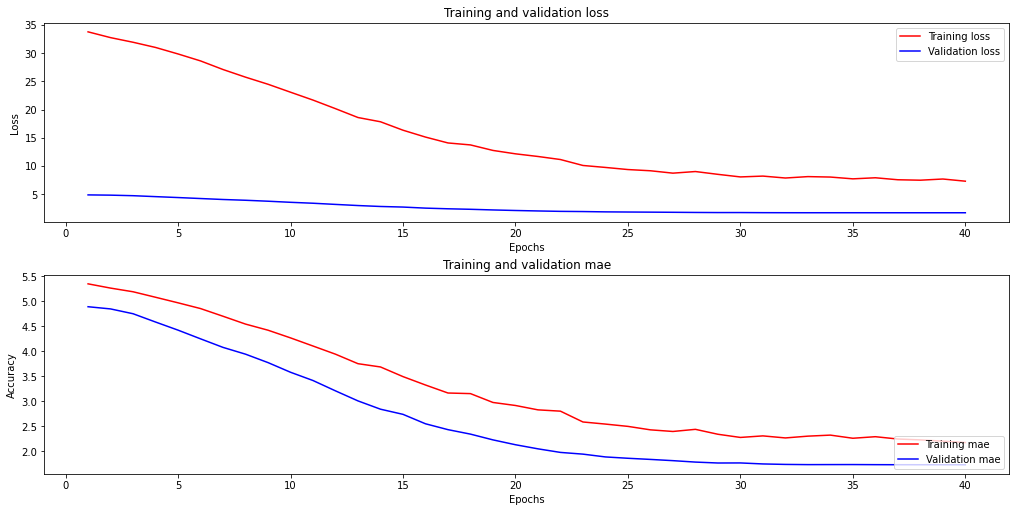

In [15]:
regressor_model.plot_training_history_over_time(figsize=(14, 7))


In [16]:
temp_path = "saved_models/regression/IMO-BERT-CASED"
regressor_model.model.save(temp_path)


### Reload model

In [2]:
reloaded_model = tf.saved_model.load('saved_models/regression/IMO-BERT-CASED')


 1. Find the smallest natural number n which has the following properties: a) Its decimal representation has a 6 as the last digit. b) If the last digit 6 is erased and placed in front of the remaining digits, the resulting number is four times as large as the original number n.
    Actual   Predicted
    0.980    4.822

 2. Construct triangle ABC, given h_a, h_b (the altitudes from A and B), and m_a, the median from vertex A.
    Actual   Predicted
    1.000    4.997

 3. Find all natural numbers n the product of whose decimal digits is n^2-10n-22.
    Actual   Predicted
    1.334    4.858

 4. Let f be an injective function from {1,2,3, ldots} in itself. Prove that for any n we have: sum_{k=1}^{n} f(k)k^{-2} geq sum_{k=1}^{n} k^{-1}.
    Actual   Predicted
    1.616    5.030

 5. Determine all composite integers n>1 that satisfy the following property: if d_1, d_2, ldots, d_k are all the positive divisors of n with 1=d_1<d_2< cdots<d_k=n, then d_i divides d_{i+1}+d_{i+2} for every 1 

,actual,predicted
0,0.980392,4.822482
1,1.000000,4.996595
2,1.334380,4.858387
3,1.616162,5.029963
4,1.734198,4.942289
5,2.136855,4.975718
6,2.212693,4.942457
7,2.214839,4.935360
8,2.225535,5.005081
9,2.362345,4.992102


           actual              predict
Average    5.16082575388927    4.910338401794434
Variance   5.326022509214558    0.03122452273964882
STD        2.3078176941029285    0.17670461535453796

loss(mse)            mae                   r2
5.527496927644771    1.9887292032561579    -0.037828307725256805


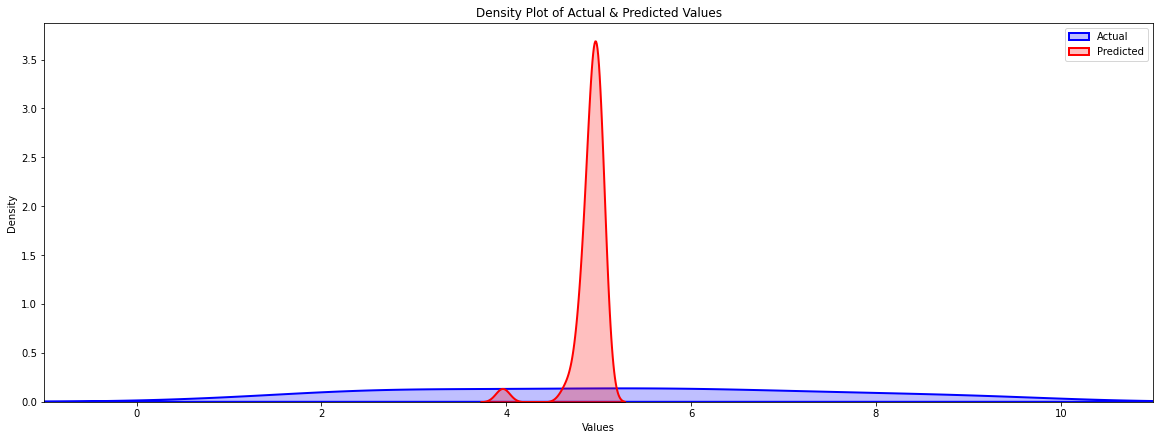

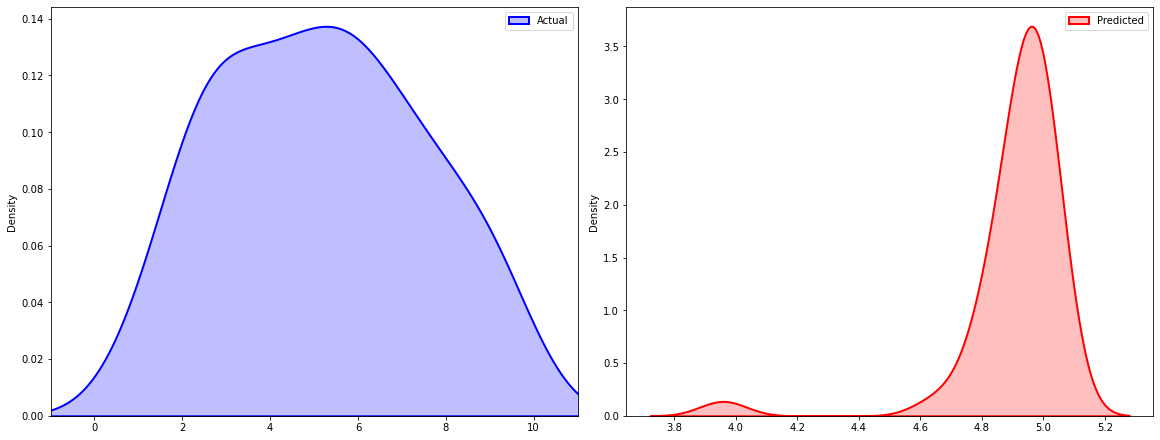

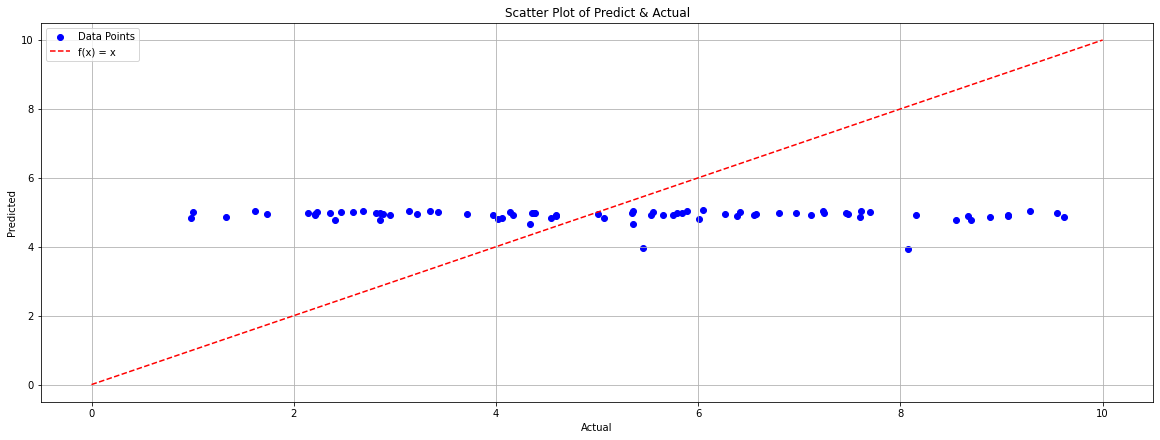

In [4]:
def compare_actual_and_predict_values(model, list_of_texts, list_of_actual):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    predicted = model(tf.constant(list_of_texts))
    predicted = predicted.numpy().flatten()
    list_of_actual = np.array(list_of_actual)
    
    for i in range(len(list_of_texts)):
        print(f"{str(i+1):>2s}. {list_of_texts[i]}")
        print(f"    Actual   Predicted")
        print(f"    {list_of_actual[i]:.3f}    {predicted[i]:.3f}")
        print()

    df_ = pd.DataFrame({
        'actual': list_of_actual,
        'predicted': predicted
    })
    pd.set_option('display.max_rows', 500)
    display(df_)
    print(f"           actual              predict")
    print(f"Average    {np.average(list_of_actual)}    {np.average(predicted)}")
    print(f"Variance   {np.var(list_of_actual)}    {np.var(predicted)}")
    print(f"STD        {np.std(list_of_actual)}    {np.std(predicted)}")
    print()

    loss_sk = mean_squared_error(y_true=list_of_actual, y_pred=predicted)
    mae_sk = mean_absolute_error(y_true=list_of_actual, y_pred=predicted)
    r2_sk = r2_score(y_true=list_of_actual, y_pred=predicted)
    print(f"loss(mse)            mae                   r2")
    print(f"{loss_sk}    {mae_sk}    {r2_sk}")

    fig, ax = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)

    plt.xlim((-1, 11))
    plt.title('Density Plot of Actual & Predicted Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()

    fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    plt.subplot(1, 2, 1)
    plt.xlim((-1, 11))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.legend()

    # Scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)
    plt.subplot(1, 1, 1)
    plt.scatter(list_of_actual, predicted, color='blue', marker='o', label='Data Points')
    fx_x = np.linspace(0, 10, 100)  # Generate x values for the line
    plt.plot(fx_x, fx_x, color='red', linestyle='--', label='f(x) = x')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of Predict & Actual')
    plt.grid(True)
    plt.legend()

    plt.show()

df = pd.read_csv("../data/regression/imo/test.csv")
df.sort_values(by=['score'], inplace=True)
df.reset_index(inplace=True)
examples_texts = df['post_canonical'].values
examples_scores = df['score'].values

compare_actual_and_predict_values(reloaded_model, examples_texts, examples_scores)


## Data `COMBINED_ALL` (RESTART BEFORE RUN BELOW!)

In [4]:
train_ds, val_ds, test_ds = load_and_prepare_dataset("../data/regression/", seed=seed, batch_size=batch_size, AUTOTUNE=AUTOTUNE)
regressor_model = RegressorModel(tfhub_handle_preprocess, tfhub_handle_encoder)
regressor_model.compile_model(train_ds=train_ds,
                                 validation_data=val_ds,
                                 epochs=epochs, 
                                 learning_rate=learning_rate, 
                                 optimizer_type=optimizer_type, 
                                 loss=loss, 
                                 metrics=metrics)


In [5]:
regressor_model.train()


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3

Epoch 1/40
27/27 [==============================] - 28s 456ms/step - loss: 53.3527 - mae: 6.9344 - val_loss: 49.9973 - val_mae: 6.7773
Epoch 2/40
27/27 [==============================] - 11s 422ms/step - loss: 52.4842 - mae: 6.8658 - val_loss: 48.7968 - val_mae: 6.6881
Epoch 3/40
27/27 [==============================] - 11s 421ms/step - loss: 50.4166 - mae: 6.7194 - val_loss: 46.5218 - val_mae: 6.5166
Epoch 4/40
27/27 [==============================] - 11s 422ms/step - loss: 48.0432 - mae: 6.5393 - val_loss: 43.1983 - val_mae: 6.2521
Epoch 5/40
27/27 [==============================] - 11s 424ms/step - loss: 44.5378 - mae: 6.2651 - val_loss: 38.9478 - val_mae: 5.9026
Epoch 6/40
27/27 [==============================] - 11s 424ms/step - 

In [6]:
result = regressor_model.evaluate_test(test_ds)
loss, mae = result['loss'], result['mae']
print()
print(f'Loss     : {loss}')
print(f'MAE      : {mae}')


8/8 [==============================] - 1s 129ms/step - loss: 5.5735 - mae: 1.9965

Loss     : 5.573544025421143
MAE      : 1.9965306520462036


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


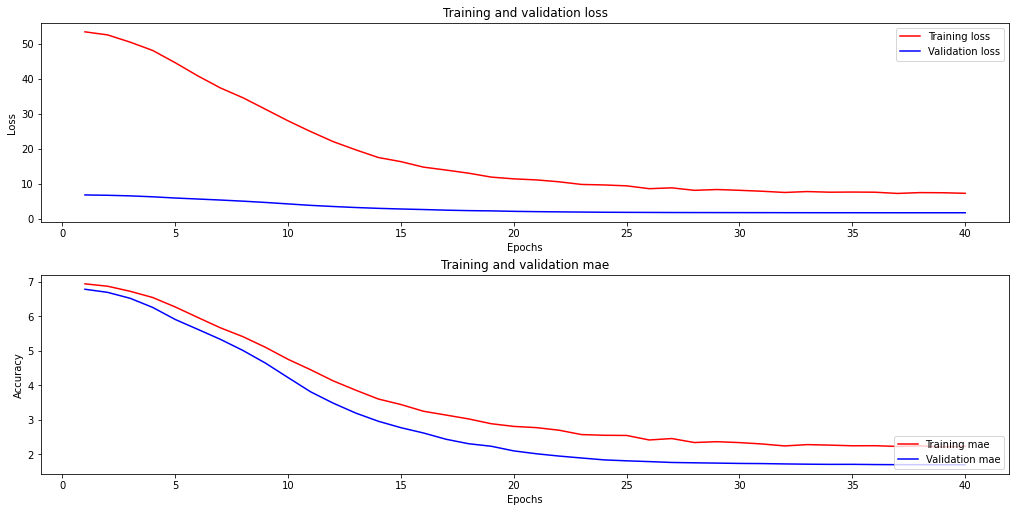

In [7]:
regressor_model.plot_training_history_over_time(figsize=(14, 7))


In [8]:
temp_path = "saved_models/regression/COMBINED_ALL-BERT-CASED"
regressor_model.model.save(temp_path)


## END

In [16]:
def build_regressor_model(tfhub_preprocess, tfhub_encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
    
    return tf.keras.Model(text_input, net)


In [17]:
regressor_model = build_regressor_model(tfhub_preprocess=tfhub_handle_preprocess, tfhub_encoder=tfhub_handle_encoder)

epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
optimizer = optimization.create_optimizer(
    init_lr=1e-4,
    num_train_steps=num_train_steps,
    num_warmup_steps=int(0.1*num_train_steps),
    optimizer_type='adamw')
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss = tf.keras.losses.mean_squared_error
metrics = ['mae']

regressor_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [18]:
history = regressor_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs
    )


Epoch 1/3


31/35 [=========================>....] - ETA: 6s - loss: 12.6548 - mae: 2.7341

ResourceExhaustedError: Graph execution error:

Detected at node 'gradients/transformer/layer_5/output/einsum/Einsum_grad/Einsum_1' defined at (most recent call last):
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\victo\AppData\Local\Temp\ipykernel_17020\1940735897.py", line 1, in <cell line: 1>
      history = regressor_model.fit(
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\victo\anaconda3\envs\aops_tenflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradients/transformer/layer_5/output/einsum/Einsum_grad/Einsum_1'
OOM when allocating tensor with shape[3072,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients/transformer/layer_5/output/einsum/Einsum_grad/Einsum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_76394]

Find all real functions $f$ defined on $\mathbb{R}$, such that $f(f(x)+y) = f(f(x)-y)+4f(x)y$ ,for all real numbers $x,y$.

In [13]:
example_text = "Find all real functions f defined on mathbb R, such that f(f(x)+y) = f(f(x)-y)+4f(x)y ,for all real numbers x,y."
regressor_model.predict(tf.constant([example_text]))


1/1 [==============================] - 0s 490ms/step


array([[6.173266]], dtype=float32)

In [14]:
loss, mae = regressor_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'MAE: {mae}')


10/10 [==============================] - 1s 62ms/step - loss: 6.2743 - mae: 2.1155
Loss: 6.2743048667907715
Accuracy: 2.1155002117156982


In [15]:
history.history

{'loss': [12.656743049621582, 5.460222244262695, 5.479800224304199],
 'mae': [2.7767105102539062, 1.910332441329956, 1.8975918292999268],
 'val_loss': [4.041679859161377, 4.939436435699463, 4.4661784172058105],
 'val_mae': [1.735615849494934, 1.845645785331726, 1.8318814039230347]}

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


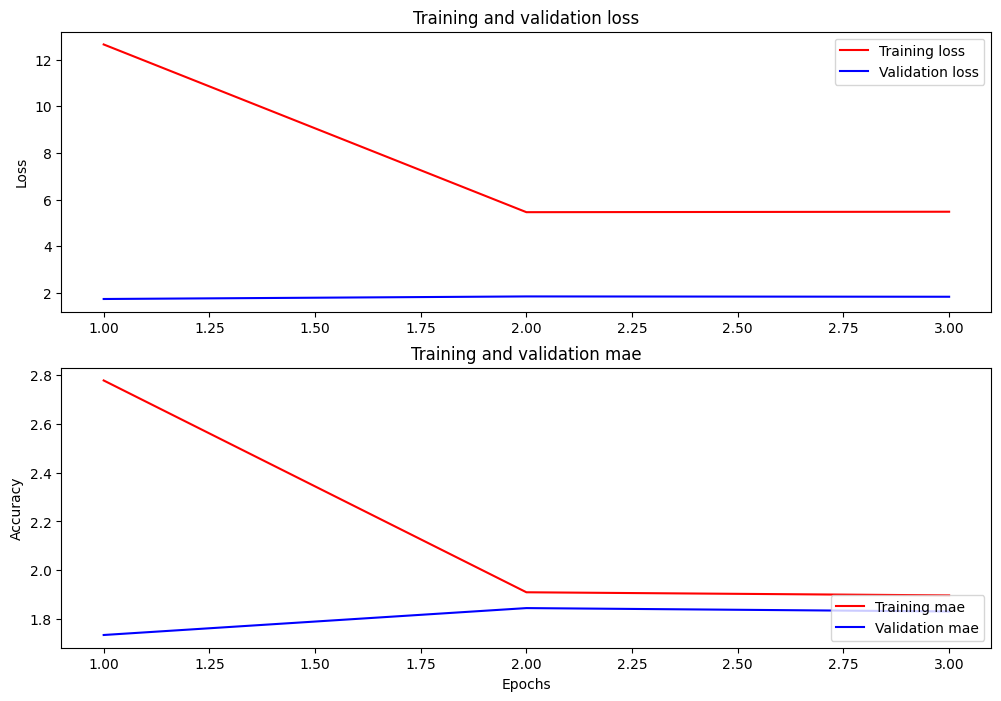

In [16]:
history_dict = history.history
print(history_dict.keys())

mae = history_dict['mae']
val_acc = history_dict['val_mae']
loss = history_dict['loss']
val_mae = history_dict['val_mae']

epochs = range(1, len(mae) + 1)
fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_mae, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
